# Introduction to early stopping in neural network training

This notebook aims to introduce the purpose of early stopping and some common early stopping techniques via an image classification example. 


In [1]:
%matplotlib inline

### Plotting functions and useful imports

You can skip this part

In [2]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].plot(x, test_loss, color=colors[2], label="Test loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].plot(x, test_acc, color=colors[2], label="Test accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()


In [3]:
# !pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
# !pip install torchmetrics
# !pip install torchvision
import numpy as np
# Import torch and create the alias "th"
# instead of writing torch.name_of_a_method() , we only need to write th.name_of_a_method()
# (similarly to numpy imported as np)
import torch as th

In [4]:
# !pip install torch torchvision torchaudio

### 1. Loading and normalizing CIFAR10 Dataset


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
seed = 2022
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [7]:
device

device(type='cpu')

### Define subset of the dataset (so it is faster to train)

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000
n_cal_samples = 1000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
cal_sampler = SubsetRandomSampler(np.arange(n_test_samples, n_test_samples + n_cal_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

In [9]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

     truck      truck        car      horse


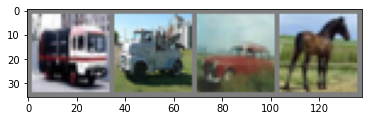

In [11]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

### 2. Define a Convolution Neural Network

In [12]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F

####  Forward propagation

In PyTorch, there are built-in functions that carry out the convolution steps for you.

- **nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0):** Convolution layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#conv2d)

- **nn.MaxPool2d(kernel_size, stride=None, padding=0):** Max pooling layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#maxpool2d)

- **F.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#torch.nn.ReLU)

- **x.view(new_shape)**: Returns a new tensor with the same data but different size. It is the equivalent of numpy function *reshape* (Gives a new shape to an array without changing its data). You can read the full documentation [here.](http://pytorch.org/docs/master/tensors.html#torch.Tensor.view)

- **nn.Linear(in_features, out_features):** Applies a linear transformation to the incoming data: $y = Ax + b$, it is also called a fully connected layer. You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#linear-layers)

#### Simple Convolutional Neural Network

ConvNet with one convolution layer followed by a max pooling operation,
one fully connected layer and an output layer

In [13]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

### 3. Define a loss function and optimizer

Let's use a Classification Cross-Entropy loss and ADAM (optionally, SGD with momentum). You can read more about  [optimization methods](https://pytorch.org/docs/stable/optim.html).



In [14]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

### 4. Train the network with early stopping


Here we implement and compare 4 early stopping rules, check following paper for details of the last 3 ESRs.


*   **Full early stopping**: Train the network for $T_{max}$ epochs where $T_{max}$ is predefined maximum number of epoch. Select the model with best validation loss.
*   **GL rule**: A class of criteria based on the validation loss, halt the training process when generality loss exceeds a predefined value.
*   **PQ rule**: A class of criteria based on both validation loss and training loss, halt the training process when validation loss is increasing and training loss is not decreasing fast enough. 
*   **UP rule**: A class of criteria only based on the sign of validation loss. Halt the training process when validation loss is increasing for several consecutive training strips.



#### Data loader

In [15]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, sampler=test_sampler,
                                         num_workers=num_workers)

#### Training loop

In [17]:
from prompt_toolkit.shortcuts import progress_bar
from torchmetrics.functional import accuracy
import pandas as pd
import pdb

class EarlyStoppedTrainer:
    def __init__(self, net, device, batch_size, n_epochs, learning_rate, verbose=True):
        """
        Initialize the early stopped trainer with specified parameters.
        """
        self.net = net.to(device)
        self.device = device
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.verbose = verbose

        if self.verbose:
            print("===== HYPERPARAMETERS =====")
            print("batch_size=", self.batch_size)
            print("n_epochs=", self.n_epochs)
            print("learning_rate=", self.learning_rate)
            print("=" * 30)

        self.train_loader = get_train_loader(self.batch_size)
        self.n_minibatches = len(self.train_loader)
        self.criterion, self.optimizer = createLossAndOptimizer(self.net, self.learning_rate)

    def train_single_epoch(self,epoch):
        """
        Train the model for a single epoch

        :return (tuple of floats) metrics of the train, validation, test sets
        """
        running_loss = 0.0
        running_acc = 0.0
        print_every = self.n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        total_train_acc = 0

        for i, (inputs, labels) in enumerate(self.train_loader):
            
            # Move tensors to correct device
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.net(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()
            running_acc += float(accuracy(outputs,labels).cpu().numpy())
            total_train_acc += float(accuracy(outputs,labels).cpu().numpy())

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} train_acc: {:.2f}% took: {:.2f}s".format(
                        epoch + 1, int(100 * (i + 1) / self.n_minibatches), running_loss / print_every,
                        100 * (running_acc / print_every), time.time() - start_time))
                running_loss = 0.0
                running_acc = 0.0
                start_time = time.time()

        total_val_loss, total_test_loss = 0, 0
        total_val_acc, total_test_acc = 0, 0
            
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
            # Do a pass on the validation set
            for inputs, labels in val_loader:
                # Move tensors to correct device
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                # Forward pass
                predictions = self.net(inputs)
                val_loss = self.criterion(predictions, labels)
                val_acc = float(accuracy(predictions,labels).cpu().numpy())
                total_val_loss += val_loss.item()
                total_val_acc += val_acc

            # Do a pass on the test set
            for inputs, labels in test_loader:
                # Move tensors to correct device
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                # Forward pass
                predictions = self.net(inputs)
                test_loss = self.criterion(predictions, labels)
                test_acc = float(accuracy(predictions,labels).cpu().numpy())
                total_test_loss += test_loss.item()
                total_test_acc += test_acc
        
        print("val_loss = {:.2f} val_acc = {:.2f}%".format(total_val_loss / len(val_loader), \
              100 * (total_val_acc / len(val_loader))))
        print("test_loss = {:.2f} test_acc = {:.2f}%".format(total_test_loss / len(test_loader), \
              100 * (total_test_acc / len(test_loader))))
 
        return total_train_loss / len(self.train_loader), total_val_loss / len(val_loader), total_test_loss / len(test_loader),\
               100 * (total_train_acc / len(self.train_loader)), 100 * (total_val_acc / len(val_loader)), 100 * (total_test_acc / len(test_loader))



    def check_gl(self, val_history, alpha=5):
        """ 
        check if the training process should be stopped by GL rule at the current epoch
        GL rule: stop if the generality loss is beyond predefined threshold

        :param val_history: (list of floats) validation loss until the current epoch
        :param alpha: (float) the stopping threshold of the ESR
        """
        min_val_loss = np.min(val_history)
        gl = 100*((val_history[-1]) / max(min_val_loss, 10**(-10)) - 1)
        return gl > alpha, gl



    def check_pq(self, train_history, val_history, k=3, alpha=0.5):
        """ 
        check if the training process should be stopped by PQ rule at the current epoch
        PQ rule: stop if quotient of progress and generality loss is beyond predefined 
        threshold
        
        :param train_history: (list of floats) training loss until the current epoch
        :param val_history: (list of floats) validation loss until the current epoch
        :param k: (int) size of the training strips
        :param beta: (float) the stopping threshold of the ESR
        """
        # If the current epoch number is not divisible by k, continue training
        if len(val_history) % k:
            return False, -1
        else:
            # Calculate the progress
            sum_k_train_loss = np.sum(train_history[-k:])
            min_k_train_loss = k * np.min(train_history[-k:])
            progress = 1000*((sum_k_train_loss / min_k_train_loss) - 1)

            # Calculate the generalization loss
            min_val_loss = np.min(val_history)
            gl = 100*((val_history[-1]) / max(min_val_loss, 10**(-10)) - 1)

            # Stopping criteria is the quotient of progress and GL
            pq = gl / progress
            return pq > alpha, pq 
    


    def check_up(self, val_history, k=1, s=3):
        """ 
        check if the training process should be stopped by UP rule at the current epoch
        UP rule: stop if the validation loss has been increasing for s consecutive 
        training strips
        
        :param val_history: (list of floats) validation loss until the current epoch
        :param k: (int) size of the training strips
        :param s: (int) number of consecutive strips
        :return max_ci: (int) maximum number of consecutive increase
        """
        if len(val_history) < k * (s+1):
            return False, -1
        
        val_loss_list = [val_history[-(k * i + 1)] for i in range(s+1)]
        increment=''
        for i in range(len(val_loss_list)-1): 
            increment += str(int(val_loss_list[i] > val_loss_list[i+1])) 
        max_ci = len(max(increment.split('0'), key=len))

        return max_ci == s, max_ci

    def es_train(self, ESR='all'):
        ESRs = ['all', 'full', 'GL', 'PQ', 'UP']
        if self.verbose:
            assert ESR in ESRs, 'Unknown early stopping rule(s)!'
            print('training with early stopping rule(s): '+ESR)

        # Save the loss history and accuracy history for plotting
        self.train_loss_history, self.val_loss_history, self.test_loss_history = [], [], []
        self.train_acc_history, self.val_acc_history, self.test_acc_history = [], [], []
        
        start_time = time.time()
        best_epoch = -1
        best_error = np.inf
        best_model_path = "best_model.pth"

        stopped_by_gl, gl_values = False, []
        stopped_by_pq, pq_values = False, []
        stopped_by_up, up_values = False, []
        
        # Save relative information for all ESR
        results =  pd.DataFrame(columns=['ESR', 'best_epoch', 'max_epoch', 'training_time', 'model_path','stopping_stats'])
        for epoch in range(self.n_epochs):
            train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = self.train_single_epoch(epoch)
            self.train_loss_history.append(train_loss)
            self.val_loss_history.append(val_loss)
            self.test_loss_history.append(test_loss)
            self.train_acc_history.append(train_acc)
            self.val_acc_history.append(val_acc)
            self.test_acc_history.append(test_acc)

            # Update the best model if the validation loss is smaller on this epoch
            if val_loss < best_error:
                best_error = val_loss
                best_epoch = epoch+1
                th.save(self.net.state_dict(), best_model_path)

            # Save the current epoch time
            epoch_time = time.time()

            # Check the GL rule if it hasn't been stopped yet
            if (not stopped_by_gl) & ((ESR=='all') | (ESR=='GL')): 
                stopped_by_gl, gl_val = self.check_gl(self.val_loss_history)
                gl_values.append(gl_val)
                # Update the relative information is the training is stopped
                if (stopped_by_gl) | (epoch==self.n_epochs-1):
                    save_path = 'gl_model.pth'
                    th.save(th.load(best_model_path), save_path)
                    results = results.append({'ESR':'GL', 'best_epoch': best_epoch, 'max_epoch':epoch+1,
                                    'training_time': epoch_time-start_time, 'model_path': save_path,
                                    'stopping_stats': gl_values}, ignore_index=True)
                    if ESR=='GL':
                        return results

            # Check the PQ rule if it hasn't been stopped yet
            if (not stopped_by_pq) & ((ESR=='all') | (ESR=='PQ')): 
                stopped_by_pq, pq_val = self.check_pq(self.train_loss_history, self.val_loss_history)
                pq_values.append(pq_val)
                # Update the relative information is the training is stopped
                if (stopped_by_pq) | (epoch==self.n_epochs-1):
                    save_path = 'pq_model.pth'
                    th.save(th.load(best_model_path), save_path)
                    results = results.append({'ESR':'PQ', 'best_epoch': best_epoch, 'max_epoch':epoch+1,
                                    'training_time': epoch_time-start_time, 'model_path': save_path,
                                    'stopping_stats': pq_values}, ignore_index=True)
                    if ESR=='PQ':
                        return results
                    
            # Check the UP rule if it hasn't been stopped yet
            if (not stopped_by_up) & ((ESR=='all') | (ESR=='UP')): 
                stopped_by_up, up_val = self.check_up(self.val_loss_history)
                up_values.append(up_val)
                # Update the relative information is the training is stopped
                if (stopped_by_up) | (epoch==self.n_epochs-1):
                    save_path = 'up_model.pth'
                    th.save(th.load(best_model_path), save_path)
                    results = results.append({'ESR':'UP', 'best_epoch': best_epoch, 'max_epoch':epoch+1,
                                    'training_time': epoch_time-start_time, 'model_path': save_path,
                                    'stopping_stats': up_values}, ignore_index=True)
                    if ESR=='UP':
                        return results

        results = results.append({'ESR':'full', 'best_epoch': best_epoch, 'max_epoch':self.n_epochs,
                                    'training_time': time.time()-start_time, 'model_path': best_model_path,
                                    'stopping_stats': None}, ignore_index=True)
        return results

    def get_loss_history(self):
        if hasattr(self, 'train_loss_history'):
            return self.train_loss_history, self.val_loss_history, self.test_loss_history
        else:
            print('Train the model first before getting loss history!')

    def get_acc_history(self):
        if hasattr(self, 'train_acc_history'):
            return self.train_acc_history, self.val_acc_history, self.test_acc_history
        else:
            print('Train the model first before getting accuracy history!')



In [18]:
seed = 2022
np.random.seed(seed)
torch.manual_seed(seed)

net = SimpleConvolutionalNetwork()

EsTrainer = EarlyStoppedTrainer(net, device, batch_size=32, n_epochs=5, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 5
learning_rate= 0.001


In [19]:
results = EsTrainer.es_train(ESR='all')

training with early stopping rule(s): all
Epoch 1, 10% 	 train_loss: 2.06 train_acc: 26.31% took: 3.23s
Epoch 1, 20% 	 train_loss: 1.84 train_acc: 34.78% took: 0.70s
Epoch 1, 30% 	 train_loss: 1.67 train_acc: 43.20% took: 0.70s
Epoch 1, 40% 	 train_loss: 1.58 train_acc: 46.27% took: 0.69s
Epoch 1, 50% 	 train_loss: 1.57 train_acc: 45.26% took: 0.69s
Epoch 1, 60% 	 train_loss: 1.51 train_acc: 49.95% took: 0.69s
Epoch 1, 70% 	 train_loss: 1.46 train_acc: 49.24% took: 0.69s
Epoch 1, 80% 	 train_loss: 1.43 train_acc: 50.10% took: 0.69s
Epoch 1, 90% 	 train_loss: 1.44 train_acc: 50.20% took: 0.69s
val_loss = 1.35 val_acc = 52.44%
test_loss = 1.35 test_acc = 52.13%
Epoch 2, 10% 	 train_loss: 1.30 train_acc: 56.00% took: 3.52s
Epoch 2, 20% 	 train_loss: 1.31 train_acc: 55.39% took: 0.79s
Epoch 2, 30% 	 train_loss: 1.30 train_acc: 55.29% took: 0.84s
Epoch 2, 40% 	 train_loss: 1.29 train_acc: 55.70% took: 0.97s
Epoch 2, 50% 	 train_loss: 1.27 train_acc: 56.60% took: 1.10s
Epoch 2, 60% 	 train_l

C:\Users\16266\AppData\Local\Temp\ipykernel_18816\2571846834.py:222: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'ESR':'GL', 'best_epoch': best_epoch, 'max_epoch':epoch+1,
C:\Users\16266\AppData\Local\Temp\ipykernel_18816\2571846834.py:236: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'ESR':'PQ', 'best_epoch': best_epoch, 'max_epoch':epoch+1,
C:\Users\16266\AppData\Local\Temp\ipykernel_18816\2571846834.py:250: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'ESR':'UP', 'best_epoch': best_epoch, 'max_epoch':epoch+1,
C:\Users\16266\AppData\Local\Temp\ipykernel_18816\2571846834.py:256: FutureWarning: The frame.append method is deprecated and will be

In [20]:
results

,ESR,best_epoch,max_epoch,training_time,model_path,stopping_stats
0,GL,5,5,89.723629,gl_model.pth,"[0.0, 0.0, 0.0, 0.0, 0.0]"
1,PQ,5,5,89.723629,pq_model.pth,"[-1, -1, 0.0, -1, -1]"
2,UP,5,5,89.723629,up_model.pth,"[-1, -1, -1, 0, 0]"
3,full,5,5,92.199912,best_model.pth,None


In [21]:
# Load one or more best models
net.load_state_dict(th.load(results.iloc[3].model_path))

<All keys matched successfully>

#### Plot the loss and prediction accuracy against the epochs.

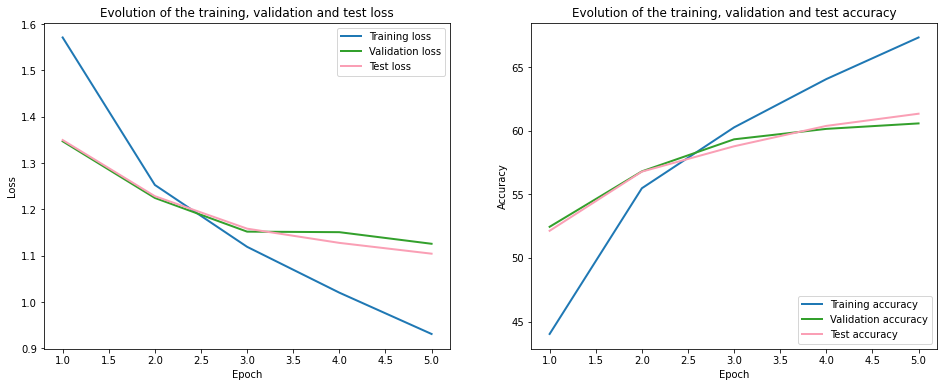

In [22]:
plot_loss_acc(*EsTrainer.get_loss_history(), *EsTrainer.get_acc_history())

## Compute conformal p-values with a seperate calibration dataset

In [23]:
import sys

!git clone https://github.com/msesia/arc
!pip install -U scikit-garden==0.1.3
!pip install -U scikit-learn==0.22
!git clone https://github.com/yromano/cqr
!git clone https://github.com/msesia/cqr-comparison
!git clone https://github.com/msesia/arc

'git' is not recognized as an internal or external command,
operable program or batch file.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\16266\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\16266\\AppData\\Local\\Temp\\pip-install-fmlopbj_\\scikit-garden_93ce81726658418ca213ee9b2a3d80ff\\setup.py'"'"'; __file__='"'"'C:\\Users\\16266\\AppData\\Local\\Temp\\pip-install-fmlopbj_\\scikit-garden_93ce81726658418ca213ee9b2a3d80ff\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\16266\AppData\Local\Temp\pip-wheel-dj2hufze'
       cwd: C:\Users\16266\AppData\Local\Temp\pip-install-fmlopbj_\scikit-garden_93ce81726658418ca213ee9b2a3d80ff\
  Complete output (58 lines):
  C:\Users\16266\anaconda3\lib\site-packages\setuptools\dist.py:757: UserWarning: Usage of dash-


  Running setup.py clean for scikit-garden
Failed to build scikit-garden
    Running setup.py install for scikit-garden: started
    Running setup.py install for scikit-garden: finished with status 'error'
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
    Running setup.py install for scikit-learn: started
    Running setup.py install for scikit-learn: finished with status 'error'
  Rolling back uninstall of scikit-learn
  Moving to c:\users\16266\anaconda3\lib\site-packages\scikit_learn-1.0.2.dist-info\
   from C:\Users\16266\anaconda3\Lib\site-packages\~cikit_learn-1.0.2.dist-info
  Moving to c:\users\16266\anaconda3\lib\site-packages\sklearn\
   from C:\Users\16266\anaconda3\Lib\site-packages\~klearn


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\16266\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\16266\\AppData\\Local\\Temp\\pip-install-gurnadau\\scikit-learn_472f95d66f8d4d3ab61e1ce383d01306\\setup.py'"'"'; __file__='"'"'C:\\Users\\16266\\AppData\\Local\\Temp\\pip-install-gurnadau\\scikit-learn_472f95d66f8d4d3ab61e1ce383d01306\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\16266\AppData\Local\Temp\pip-wheel-0bc2br_h'
       cwd: C:\Users\16266\AppData\Local\Temp\pip-install-gurnadau\scikit-learn_472f95d66f8d4d3ab61e1ce383d01306\
  Complete output (35 lines):
  Partial import of sklearn during the build process.
  No module named 'numpy.distutils._msvccompi

'git' is not recognized as an internal or external command,
operable program or batch file.
'git' is not recognized as an internal or external command,
operable program or batch file.
'git' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import sys
sys.path.append('/content/cqr')
sys.path.append('/content/cqr-comparison')
sys.path.append('/content/arc')

import arc
from arc import models
from arc import methods
from arc import black_boxes
from arc import others
from arc import coverage

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

In [ ]:
def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y):
    coverage, length, length_cover = evaluate_predictions(S, y)
    print('Marginal coverage:       {:2.3%}'.format(coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

In [ ]:
# Load a seperate calibration data exchangeble with test data
cal_loader = torch.utils.data.DataLoader(test_set, batch_size=n_cal_samples, sampler=cal_sampler,
                                         num_workers=1)

In [ ]:
from arc.classification import ProbabilityAccumulator as ProbAccum
from scipy.stats.mstats import mquantiles

class SplitConformal:
    """
    Prediction sets by split conformal method, modified from https://github.com/msesia/arc
    """
    def __init__(self, cal_loader, black_box, device, alpha, random_state=2022, allow_empty=True, verbose=False):
        """
        :param cal_loader: (dataloader) dataloader that loads all calibration data at once
        :param black_box: (nn) trained neural network
        :param device: (cpu or gpu) location of the network
        :param alpha: (float) confidence level
        """
        self.allow_empty = allow_empty
        self.black_box = black_box
        self.device = device

        # Load the calibration data all at once
        X_calib, Y_calib = next(iter(cal_loader))

        # Form prediction sets on calibration data
        logits = self.black_box(X_calib.to(self.device))
        self.predict_proba = nn.Softmax(dim=1)
        with th.no_grad():
            p_hat_calib = self.predict_proba(logits).cpu().numpy()
        grey_box = ProbAccum(p_hat_calib)

        n2 = X_calib.shape[0]
        rng = np.random.default_rng(random_state)
        epsilon = rng.uniform(low=0.0, high=1.0, size=n2)
        alpha_max = grey_box.calibrate_scores(Y_calib, epsilon=epsilon)
        scores = alpha - alpha_max
        level_adjusted = (1.0-alpha)*(1.0+1.0/float(n2))
        alpha_correction = mquantiles(scores, prob=level_adjusted)

        # Store calibrate level
        self.alpha_calibrated = alpha - alpha_correction

    def predict(self, X_test, random_state=2020):
        """
        Compute prediction sets for given test point(s)
        :param X_test: (tensor) features of the test point in tensor form
        :return S_hat: (array-like) prediction set of the test point
        """
        n = X_test.shape[0]
        rng = np.random.default_rng(random_state)
        epsilon = rng.uniform(low=0.0, high=1.0, size=n)
        logits = self.black_box(X_test.to(self.device))
        with th.no_grad():
            p_hat = self.predict_proba(logits).cpu().numpy()
        grey_box = ProbAccum(p_hat)
        S_hat = grey_box.predict_sets(self.alpha_calibrated, epsilon=epsilon, allow_empty=self.allow_empty)
        return S_hat

#### Load test data, compute prediction sets and evaluate the coverage.

In [ ]:
alpha = 0.1
PredSets_sc = SplitConformal(cal_loader, net, device, alpha)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=1)
# get all test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [ ]:
S_sc = PredSets_sc.predict(images)
evaluate_marginal(S_sc, labels.numpy())
print('='*50)
evaluate_conditional(S_sc, labels.numpy())

Marginal coverage:       90.040%
Average size:            2.940
Average size | coverage: 2.955
Conditional coverage for label plane:       91.189%
Average size:            2.709
Average size | coverage: 2.733
Conditional coverage for label car:       92.871%
Average size:            2.180
Average size | coverage: 2.213
Conditional coverage for label bird:       84.766%
Average size:            3.660
Average size | coverage: 3.832
Conditional coverage for label cat:       90.946%
Average size:            3.777
Average size | coverage: 3.881
Conditional coverage for label deer:       85.404%
Average size:            3.795
Average size | coverage: 3.873
Conditional coverage for label dog:       91.598%
Average size:            3.311
Average size | coverage: 3.271
Conditional coverage for label frog:       91.650%
Average size:            2.578
Average size | coverage: 2.536
Conditional coverage for label horse:       90.303%
Average size:            3.010
Average size | coverage: 2.991
Co

#### Plot some images and their prediction sets.

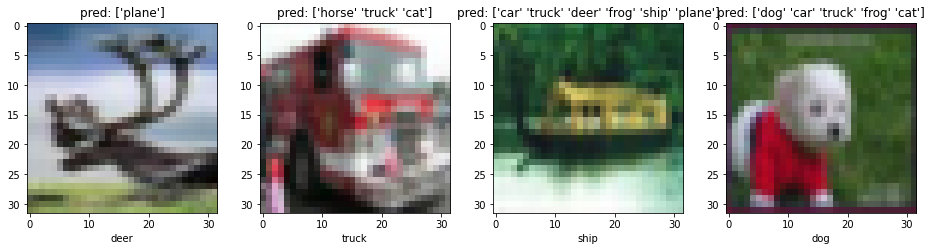

In [ ]:
n_plots = 4
plot_indices = np.random.choice(np.arange(0,n_test_samples),n_plots)

fig,axs = plt.subplots(1, n_plots, figsize=(16,3.5))
for i in range(n_plots):
    # Convert tensor images to np image for plotting
    idx = plot_indices[i]
    img = get_image(images[idx])
    axs[i].imshow(img)
    axs[i].set_xlabel(str(np.array(classes)[labels[idx]]))
    axs[i].set_title('pred: '+str(np.array(classes)[S_sc[idx]]))